## Project Description

MLB Advanced Media, as stated in a job description for which I was intrigued by, was looking to develop insights into predictability of a hit based on data acquired through their Statcast tool. Statcast is a high-speed, high-accuracy device that tracks ball and player movements. 

The findings of this task would be for use by analysts and commentators during game broadcasts. The problem statement for the specfic prediction I undertook is:

Based on the ballistics of the pitch and the ball hit into play, what is the likelihood it results in a hit.

## Notebook Description

2\. **Clean data** by handling null values and adjusting data types and **engineer features** necessary for analysis

- Read in and inspect data from Postres
- Inspect null-values, determine null definitions, and incorporate null-handling procedures

|   Fields   |   Null Meaning  |   Data Type   |
| -----------|:---------------:|--------------:|
| pitch | unknown | Object |
| mph | unknown | Float |
| ev_mph | ball not hit | Float |
| dist | ball not hit | Integer |
| spin_rate | unknown | Integer |
| launch_angle | ball not hit | Float |
| zone | unknown | Object |
| ab_result | pitch did not end ab | Object | 

- Correct data types
- Merge in pitch types to provide clarity to the abbreviated field `pitch`
- Using `pitch_results` and `ab_result`, create `hit_flag` field to be used as modeling target
- Pickle data

___________

### Initialize packages and create Postgres connection

In [1]:
# ! pip install missingno --quiet

In [2]:
% run __init__.py

In [3]:
def connect_to_db(host='postgres', dbname='postgres', user='postgres', password='postgres', port=5432):
    con = pg2.connect(host=host, dbname=dbname, user=user)
    cur = con.cursor(cursor_factory=RealDictCursor)
    
    url = 'postgresql://{}:{}@{}:{}/{}'
    url = url.format(user, password, host, port, dbname)
    engine = create_engine(url)
    
    return con, cur, engine

# split cursor/connection from engine

In [4]:
con, cur, engine = connect_to_db()

In [5]:
engine.table_names()

['pitchers']

### Read in Data from Postgres

In [6]:
sql = """
SELECT * FROM pitchers
"""
df = pd.read_sql(sql, con=engine)

In [7]:
df.set_index('unique_id', inplace=True)
df.head()

,player_id,pitch,mph,ev_mph,pitcher,batter,dist,spin_rate,launch_angle,perceived_vel,zone,game_date,ab_count,inning,pitch_result,ab_result
unique_id,,,,,,,,,,,,,,,,
434378-1,434378,FF,97.2,NaN,Justin Verlander,Rougned Odor,NaN,2526.0,NaN,None,11.0,2017-09-27,2-2,Bot 6,swinging_strike,Rougned Odor strikes out swinging.
434378-2,434378,FF,96.5,78.9,Justin Verlander,Rougned Odor,195.0,2581.0,23.5971,None,1.0,2017-09-27,2-2,Bot 6,foul,None
434378-3,434378,FF,97.0,77.2,Justin Verlander,Rougned Odor,221.0,2507.0,38.4774,None,11.0,2017-09-27,2-2,Bot 6,foul,None
434378-4,434378,CH,88.2,NaN,Justin Verlander,Rougned Odor,NaN,1786.0,NaN,None,14.0,2017-09-27,1-2,Bot 6,ball,None
434378-5,434378,CH,87.8,NaN,Justin Verlander,Rougned Odor,NaN,1762.0,NaN,None,13.0,2017-09-27,0-2,Bot 6,ball,None


### Preliminary EDA

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
player_id,721436.0,535093.470836,75171.533840,112526.0000,475479.00000,543272.00000,596001.000000,664701.00
mph,715715.0,88.637119,6.020190,36.4000,84.50000,90.00000,93.300000,104.20
ev_mph,202658.0,81.504538,16.416798,3.4000,71.80000,82.80000,94.200000,129.80
dist,188786.0,164.686147,121.408012,1.0000,36.00000,172.00000,256.000000,573.00
spin_rate,701269.0,2219.479321,309.266169,413.0000,2076.00000,2242.00000,2403.000000,3680.00
launch_angle,202678.0,15.889613,29.138029,-87.1272,-3.81675,17.25705,36.124975,89.85
zone,715562.0,9.109047,4.210689,1.0000,5.00000,11.00000,13.000000,14.00


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 721436 entries, 434378-1 to 621056-5
Data columns (total 16 columns):
player_id        721436 non-null int64
pitch            715711 non-null object
mph              715715 non-null float64
ev_mph           202658 non-null float64
pitcher          721436 non-null object
batter           721436 non-null object
dist             188786 non-null float64
spin_rate        701269 non-null float64
launch_angle     202678 non-null float64
perceived_vel    0 non-null object
zone             715562 non-null float64
game_date        721436 non-null object
ab_count         721436 non-null object
inning           721436 non-null object
pitch_result     721436 non-null object
ab_result        184869 non-null object
dtypes: float64(6), int64(1), object(9)
memory usage: 93.6+ MB


In [10]:
df.drop('perceived_vel', axis=1, inplace=True)

### Null-handling

** import missing no package to graph nulls. msno.bar() **

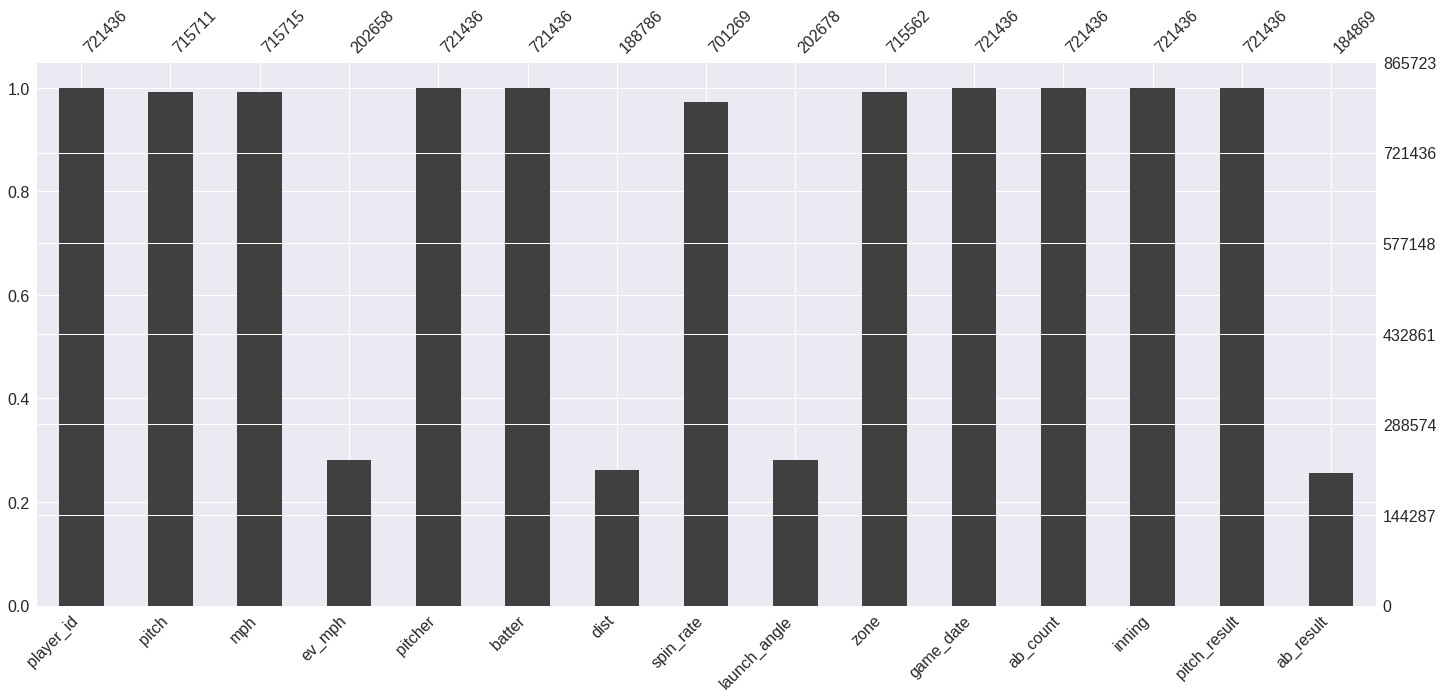

In [11]:
msno.bar(df)

In [12]:
df_nulls = df[df.ab_result.isnull()]

In [13]:
df_nulls.ab_result.unique()

array([None], dtype=object)

** Defining meaning of null values for fields with nulls **

|   Fields   |   Null Meaning  |   Data Type   |
| -----------|:---------------:|--------------:|
| pitch | unknown | Object |
| mph | unknown | Float |
| ev_mph | ball not hit | Float |
| dist | ball not hit | Integer |
| spin_rate | unknown | Integer |
| launch_angle | ball not hit | Float |
| zone | unknown | Object |
| ab_result | pitch did not end ab | Object | 

** For `pitch`, nulls mean the pitch type is unknown and there is an existing category for that **

In [14]:
df.pitch.replace(to_replace=np.nan, value='UN', inplace=True)

In [15]:
df.pitch.unique()

array(['FF', 'CH', 'SL', 'CU', 'UN', 'FC', 'FS', 'FT', 'PO', 'KC', 'EP',
       'KN', 'AB', 'SI', 'SC', 'FO', 'IN'], dtype=object)

**For `mph`, nulls mean the statcast device was not able to pick up and record the speed of the pitch. For now we will use the average mph to try and minimize the effect on our outcome.**

In [16]:
df.mph.replace(to_replace=np.nan, value=np.mean(df.mph), inplace=True)

In [17]:
df.mph.isnull().unique()

array([False], dtype=object)

**For `ev_mph`, nulls mean that the ball was not hit in play. For this case I will replace `nulls` with `0`.**

In [18]:
df.ev_mph.replace(to_replace=np.nan, value=0, inplace=True)

In [19]:
df.ev_mph.isnull().unique()

array([False], dtype=object)

**For `dist`, nulls mean that the ball was not hit in play. For this case I will replace `nulls` with `0`. As a precaution, I confirmed that no balls hit in play were hit 0 feet.**

In [20]:
df.dist.replace(to_replace=np.nan, value=0, inplace=True)

In [21]:
df.dist.isnull().unique()

array([False], dtype=object)

**For `spin_rate`, nulls mean the statcast device was not able to pick up and record the speed of the pitch. For now we will use the average spin rate to try and minimize the effect on our outcome.**

In [22]:
df.spin_rate.replace(to_replace=np.nan, value=np.mean(df.mph), inplace=True)

In [23]:
df.spin_rate.isnull().unique()

array([False], dtype=object)

**For `launch_angle`, nulls mean that the ball was not hit in play. For this case I will replace `nulls` with `0`. Those records won't be included in the modeling for hit/no hit because the pitch was not hit into play anyway.**

In [24]:
df.launch_angle.replace(to_replace=np.nan, value=0, inplace=True)

In [25]:
df.launch_angle.isnull().unique()

array([False], dtype=object)

**For `zone`, nulls mean the statcast device was not able to pick up and record which part of the strike zone the pitch crossed. Since this will later be converted to type `object`, I will save these values as the string `unknown`.**

In [26]:
df.zone.replace(to_replace=np.nan, value='unknown', inplace=True)

In [27]:
df.zone.unique()

array([11.0, 1.0, 14.0, 13.0, 12.0, 2.0, 6.0, 5.0, 7.0, 8.0, 3.0, 4.0, 9.0,
       'unknown'], dtype=object)

**For `ab_result`, nulls mean that the ball was not hit in play. For this case I will replace `nulls` with `ball not hit in play`. **

In [28]:
df.ab_result.replace(to_replace=np.nan, value='ball not hit in play', inplace=True)

In [29]:
df.ab_result.isnull().unique()

array([False], dtype=object)

### Data Type Clean-up

** Converting `dist` and `spin_rate` to type `int`**

In [30]:
df[['dist', 'spin_rate']] = df[['dist', 'spin_rate']].astype('int')

** Converting `zone` to type `str` while removing the decimal place from zone values where pertinent **

In [31]:
df[['zone']] = df[['zone']].astype('str')

In [32]:
df.zone.unique()

array(['11.0', '1.0', '14.0', '13.0', '12.0', '2.0', '6.0', '5.0', '7.0',
       '8.0', '3.0', '4.0', '9.0', 'unknown'], dtype=object)

### Mapping in data for pitch type

In [33]:
cd ..

/home/jovyan


In [34]:
pitch_type_data = pd.read_csv('data/pitch_types.csv')

In [35]:
pitch_type_data.head()

,full_pitch,pitch,pitch_rollup
0,Four-Seam Fastball,FF,fastball
1,Two-Seam Fastball,FT,fastball
2,Fastball (cutter),FC,fastball
3,Fastball (sinker/split-fingered),FS,fastball
4,Fastball (sinker/split-fingered),SI,fastball


In [36]:
df_merged = df.merge(pitch_type_data, on='pitch', how='left').set_index(df.index)

### Creating field for flag `hit` or `no_hit`

In [37]:
df_merged.head(2)

,player_id,pitch,mph,ev_mph,pitcher,batter,dist,spin_rate,launch_angle,zone,game_date,ab_count,inning,pitch_result,ab_result,full_pitch,pitch_rollup
unique_id,,,,,,,,,,,,,,,,,
434378-1,434378,FF,97.2,0.0,Justin Verlander,Rougned Odor,0,2526,0.0000,11.0,2017-09-27,2-2,Bot 6,swinging_strike,Rougned Odor strikes out swinging.,Four-Seam Fastball,fastball
434378-2,434378,FF,96.5,78.9,Justin Verlander,Rougned Odor,195,2581,23.5971,1.0,2017-09-27,2-2,Bot 6,foul,ball not hit in play,Four-Seam Fastball,fastball


In [38]:
df_merged.pitch_result.unique()

array(['swinging_strike', 'foul', 'ball', 'hit_into_play', 'called_strike',
       'hit_into_play_score', 'hit_into_play_no_out',
       'swinging_strike_blocked', 'foul_tip', 'blocked_ball',
       'hit_by_pitch', 'automatic_ball', 'foul_bunt', 'missed_bunt',
       'pitchout'], dtype=object)

In [39]:
pd.set_option('display.max_colwidth', -1)

In [40]:
df_merged['hit_flag'] = df_merged['ab_result'].map(lambda x: re.search('singles|doubles|triples|homers', x) != None)

In [41]:
df_merged[df_merged['pitch_result'] == 'hit_into_play_no_out'].sample(3)

,player_id,pitch,mph,ev_mph,pitcher,batter,dist,spin_rate,launch_angle,zone,game_date,ab_count,inning,pitch_result,ab_result,full_pitch,pitch_rollup,hit_flag
unique_id,,,,,,,,,,,,,,,,,,
519008-281,519008,SI,89.5,97.4,T.J. McFarland,Denard Span,339,1940,18.500,14.0,2017-08-05,0-1,Bot 10,hit_into_play_no_out,Denard Span doubles (24) on a line drive to right fielder J. Martinez.,Fastball (sinker/split-fingered),fastball,True
453284-832,453284,FF,95.5,97.2,Blake Parker,Kyle Seager,67,2232,1.941,4.0,2017-05-03,1-1,Bot 8,hit_into_play_no_out,Kyle Seager singles on a ground ball to center fielder Mike Trout.,Four-Seam Fastball,fastball,True
476451-2620,476451,FF,92.0,73.6,Jeremy Hellickson,Jose Peraza,182,2033,17.845,1.0,2017-04-03,0-2,Bot 1,hit_into_play_no_out,Jose Peraza singles on a line drive to right fielder Michael Saunders.,Four-Seam Fastball,fastball,True


### Saving final dataframes for each classification model, pitch ballistics and hit ballistics

In [42]:
df_master = df_merged.copy()

In [43]:
# df_pitch_init = df_merged.copy()

In [44]:
# df_pitch_init.columns

In [45]:
# df_pitch_clf = df_pitch_init.drop(['ev_mph', 'dist', 'launch_angle'], axis=1)

In [46]:
# df_pitch_clf.shape

In [47]:
df_in_play_init = df_merged.copy()

In [48]:
df_in_play_init.pitch_result.unique()

array(['swinging_strike', 'foul', 'ball', 'hit_into_play', 'called_strike',
       'hit_into_play_score', 'hit_into_play_no_out',
       'swinging_strike_blocked', 'foul_tip', 'blocked_ball',
       'hit_by_pitch', 'automatic_ball', 'foul_bunt', 'missed_bunt',
       'pitchout'], dtype=object)

In [49]:
df_in_play = df_in_play_init[(df_in_play_init['pitch_result'] == 'hit_into_play') | 
                             (df_in_play_init['pitch_result'] == 'hit_into_play_score') |
                             (df_in_play_init['pitch_result'] == 'hit_into_play_no_out')]

In [50]:
df_in_play['pitch_result'].unique()

array(['hit_into_play', 'hit_into_play_score', 'hit_into_play_no_out'], dtype=object)

In [51]:
df_in_play.shape

(127052, 18)

### Write DFs for modeling `to_pickle`

In [53]:
df_in_play.to_pickle('data/in_play.p')